# CNNs and RNNs


In this unit we will talk about teh Convolution Neural Network (CNN) and Recurrent Neural Network (RNN), as well as introducing how you can build them through using the module pytorch. 

# The Convolution

In order to understand a CNN it is worth spending some time talking about the convolution. 

The idea of a convolution is to pass one system through another. If a system is though of as a function, it is the idea of taking every output of each function for every input and combining them in some way. In our case we can simulate this by passing a kernel over our image. On initialization the kernel has random values, but the values can be learned through the training process. 

The kernel we convolve with can be any value, and the size, stride and padding is a hyper parameter a model can be trained on. 

The kernel acts as a way to consolidate information as it passes throughout the model. The output of the kernel and the data is known as a feature map. This creates a "high level features" on our feature map. It can be thought of as finding higher level patterns in our data. The more kernels we have the "features" we tend to learn.

Large kernels can learn more global patterns or high level details, while small kernels can help learn more detailed patterns. 

As the feature map information is passed through multiple kernels, a single value later down the network represents many values closer to the input of the feature map.

https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html
https://www.striveworks.com/blog/demystifying-computer-vision-the-power-of-convolution-in-neural-networks#:~:text=What%20Is%20Convolution%3F
https://www.youtube.com/watch?v=kebSR2Ph7zg

Interesting Kernels: https://en.wikipedia.org/wiki/Kernel_(image_processing)

# Pytorch

Pytorch is a machine learning library created by Facebook/Meta, it is open source and created under the Linux Foundation. This along with TensorFlow is one of the most powerful open source machine learning libraries available. You can learn more about pytorch in the link below.

https://pytorch.org/


Pytorch as many of the same steps as scikit learn, however since pytorch's power comes from its ability to be more granular, there is a bit more setup involved. However, this gives us much more flexibility on our data. 

1. Import the data
2. Setup the dataset class
3. Feed into a data loader
4. Build your model
5. Train your model
6. Evaluate the results

There are many many resources online, so I encourage you to look at examples! 

Pytorch relies heavily on you to create classes, so if you are a bit rusty please check out online resources for class creation in python.

In [107]:
# Example inspired heavily from https://www.kaggle.com/code/tiiktak/fashion-mnist-with-alexnet-in-pytorch-92-accuracy
# 1. Import the data
# Data source: https://www.kaggle.com/datasets/zalando-research/fashionmnist?resource=download

import zipfile
import torch
# Unzip the Data
with zipfile.ZipFile('./fashion-mnist_test.csv.zip', 'r') as zip:
    zip.extractall('fashion-mnist_test')

with zipfile.ZipFile('./fashion-mnist_train.csv.zip', 'r') as zip:
    zip.extractall('fashion-mnist_train')

import pandas as pd

fashion_train_csv = pd.read_csv('./fashion-mnist_train/fashion-mnist_train.csv')
fashion_test_csv = pd.read_csv('./fashion-mnist_test/fashion-mnist_test.csv')

CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [86]:
# Setup for Datasets
print(fashion_train_csv.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [87]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        # Is there a better way to do this :)
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label
    
from torchvision import transforms, datasets
# Feed into our dataset

preprocess = transforms.Compose([
    transforms.ToTensor(),
])

fashion_train_dataset = FashionDataset(fashion_train_csv, preprocess)
fashion_test_dataset = FashionDataset(fashion_test_csv, preprocess)


In [126]:
from torch.utils.data import DataLoader
# Feed into a data loader
BATCH_SIZE = 64
fashion_train_loader = DataLoader(fashion_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=BATCH_SIZE, shuffle=True) 

torch.Size([64, 1, 28, 28])
torch.Size([64])
Shirt


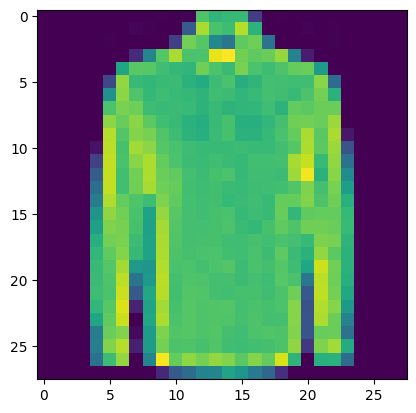

In [121]:
# Visualize Data
import matplotlib.pyplot as plt
for batch, labels in fashion_train_loader:
    print(batch.shape)
    print(labels.shape)
    plt.imshow(batch[0].squeeze())
    print( CLASS_NAMES[labels[0]])
    break

In [152]:
# Build the model
import torch.nn as nn
# There is a lot of nuance here


class fashion_mnist_model(nn.Module):
    def __init__(self):
        super(fashion_mnist_model, self).__init__()
        # Create the layers we want to use
        # Made these up for this example
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=22 * 22, out_features=1)
        self.relu = nn.ReLU()


    def forward(self, x : torch.Tensor):
        # Use the layers we created to do a feed forward of our data
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.fc1(x)
        return x

# Look at all of these hyperparameters!
model = fashion_mnist_model()
for batch, labels in fashion_train_loader:
    out = model(batch)
    print(out.shape)
    break

torch.Size([64, 484])
torch.Size([64, 1])


# Convolution Neural Networks (CNN)

# AlexNet Example

One useful aspect of pytorch is we can use existing models provided. Granted these are academic model, but they allow us to use the structures right out of the box. We can then train on data without setup for the model. We still need to setup unpacking our data and loading it into datasets, but this way we dont need to create a model object from scratch. 



In [ ]:
from torchvision.models import AlexNet, AlexNet_Weights
from torchvision import transforms
import torchvision
import torch
# Get the dataset ready
# Wnat to use mnist dataset I think 

# TODO: Get the test dataset out and 

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3, ),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.5], std=[0.25]),
    
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                           transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)



# Note if you had your own data you would want to use 
#torch.utils.data.Dataset OR torch.utils.data.TensorDataset(X, y)
#torch.utils.data.DataLoader(input_dataset, batch_size, etc)

# For torch.utils.data.Dataset() you will need to make a class 
# you must make a __init__, __len__ and __getitem__ methods before it can be used
# See example here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html




In [ ]:
# Visualize the Data
import matplotlib.pyplot as plt
for batch, label in train_loader:
    print(batch.shape)
    print(label[0])
    plt.imshow(batch[0].squeeze()[0])
    break
    

In [ ]:
from torchvision.models import alexnet, AlexNet_Weights

# Load the model
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# Set it to eval mode to prevent learning
model.eval()

for batch, label in train_loader:

    output = model(batch)
    print(output[0])
    print(label[0])
    break

# Recurrent Neural Networks (RNN)